# Cryptocurrency Market Predictor - Recurrent Neural Network

Predicting BTCUSD market

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
dataset = pd.read_csv('C:\\Users\\Jason\\Documents\\Python\\Stock Market Prediction\\Crypto\\BTC_Slopes.csv', nrows=2500)
dataset.tail(2)

,order_date_time,id,trade_px,future_px,abqdt,abqdt^2,abq,abq5,abratio,ratio5,ratio5dt,sign_vol,trade_volume,price_change,before price_change,god_mode
2498,2017-10-04 14:53:19,145778.0,4214.455,4214.460,-0.273750,-0.821250,0.984986,1.734381,0.985221,0.575636,0.039298,-0.044181,0.000014,0.005,1,-1830.726323
2499,2017-10-04 14:53:24,145792.5,4214.460,4214.865,0.152569,-0.035455,-0.110017,0.314983,0.473930,0.511663,0.034757,0.000002,0.152569,0.405,1,-1830.726323


#### Normalize

In [3]:

tdt=dataset.iloc[:, 0:2]
tdt.head(2)
dataset = dataset.drop('order_date_time', 1)
dataset.head()

,id,trade_px,future_px,abqdt,abqdt^2,abq,abq5,abratio,ratio5,ratio5dt,sign_vol,trade_volume,price_change,before price_change,god_mode
0,230.00,4296.6550,4299.025000,-4.792965,3.650850,-14.542187,-11.503253,0.002054,0.255396,-0.113188,-0.077214,0.024607,2.370000,1,-1830.726323
1,339.25,4299.0250,4297.917500,0.408871,0.238955,0.342174,4.493540,0.942512,0.666452,-0.057212,0.155947,0.126628,-1.107500,1,-1830.726323
2,349.75,4297.9175,4299.045000,-0.505025,0.364529,-0.694925,-0.708242,0.234661,0.464857,-0.014130,0.004398,0.000558,1.127500,1,-1830.726323
3,363.00,4299.0450,4299.510000,-0.285001,0.114999,0.185000,2.002783,0.930233,0.539086,0.048611,0.000001,0.000002,0.465000,1,-1830.726323
4,373.00,4299.5100,4299.208333,1.014629,-0.332311,1.590950,1.523460,0.981576,0.526442,0.033996,-0.002221,0.000002,-0.301667,1,-1830.726323


In [4]:
price_changeRange=dataset["price_change"].max() - dataset["price_change"].min()
price_changeMean = dataset["price_change"].mean()
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm["before price_change"]=0
datasetNorm.head(3)

,id,trade_px,future_px,abqdt,abqdt^2,abq,abq5,abratio,ratio5,ratio5dt,sign_vol,trade_volume,price_change,before price_change,god_mode
0,-0.454136,0.295945,0.308434,-0.064459,0.050085,-0.103356,-0.061836,-0.548517,-0.280187,-0.164432,-0.014641,-0.019048,0.103702,0,-inf
1,-0.453797,0.308163,0.302724,0.006692,0.002993,0.005631,0.018005,0.391940,0.139014,-0.083220,0.044637,-0.008222,-0.045163,0,-inf
2,-0.453764,0.302454,0.308537,-0.005808,0.004726,-0.001963,-0.007957,-0.315910,-0.066575,-0.020715,0.006108,-0.021600,0.050513,0,-inf


In [5]:
price_changeRange

23.359999999996944

## Hyperparams

In [6]:
num_epochs = 20

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 1 #The size of the sequence

state_size = 5#The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 500

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 2500
The current configuration gives us 2500 batches of 1 observations each one looking 1 steps in the past


## Train-Test split

In [7]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [8]:
datasetTrain.head(2)

,id,trade_px,future_px,abqdt,abqdt^2,abq,abq5,abratio,ratio5,ratio5dt,sign_vol,trade_volume,price_change,before price_change,god_mode
0,-0.454136,0.295945,0.308434,-0.064459,0.050085,-0.103356,-0.061836,-0.548517,-0.280187,-0.164432,-0.014641,-0.019048,0.103702,0,-inf
1,-0.453797,0.308163,0.302724,0.006692,0.002993,0.005631,0.018005,0.391940,0.139014,-0.083220,0.044637,-0.008222,-0.045163,0,-inf


In [9]:
datasetTest.head(2)

,id,trade_px,future_px,abqdt,abqdt^2,abq,abq5,abratio,ratio5,ratio5dt,sign_vol,trade_volume,price_change,before price_change,god_mode
2000,-0.364494,0.416173,0.442273,-0.095114,0.096784,-0.091128,0.015546,-0.337564,0.009105,-0.036648,-0.058444,0.417517,0.216716,0,-inf
2001,-0.364176,0.442002,0.453460,0.010468,0.021682,-0.132616,-0.099627,-0.495842,-0.373134,0.073171,-0.221754,0.007260,0.095141,0,-inf


In [10]:
#Pick appropriate columns to train
xTrain = datasetTrain[['abq5','abratio','ratio5','abqdt']].as_matrix()
yTrain = datasetTrain['price_change'].as_matrix()
#, 'vol10','ratio10','ratio30', 'vol30'

In [11]:
print(xTrain[0:2],'\n',yTrain[0:2])

[[-0.06183604 -0.54851721 -0.28018651 -0.06445857]
 [ 0.0180051   0.39194044  0.13901384  0.00669244]] 
 [ 0.10370248 -0.0451631 ]


In [12]:
#Pick appropriate columns to test
xTest = datasetTest[['abq5','abratio','ratio5','abqdt']].as_matrix()
yTest = datasetTest['price_change'].as_matrix()
#,'vol10','ratio10','ratio30', 'vol30'

In [13]:
print(xTest[0:2],'\n',yTest[0:2])

[[ 0.01554612 -0.3375643   0.00910453 -0.09511424]
 [-0.09962724 -0.49584218 -0.37313366  0.01046849]] 
 [ 0.21671618  0.09514084]


## Visualize starting price data

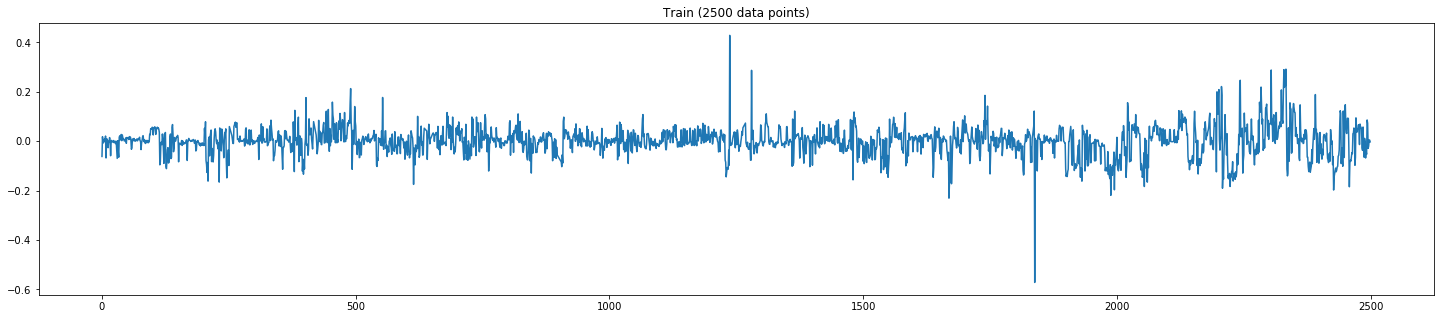

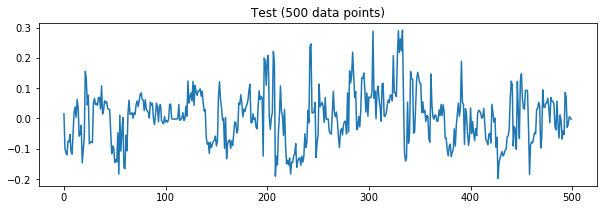

In [14]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders

In [15]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [16]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [17]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [18]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [19]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [20]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [21]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [22]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [23]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\Users\Jason\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [24]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 200 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.010775
Step 200 - Loss: 0.003567
Step 400 - Loss: 0.000000
Step 600 - Loss: 0.001311
Step 800 - Loss: 0.000106
Step 1000 - Loss: 0.000350
Step 1200 - Loss: 0.000564
Step 1400 - Loss: 0.000206
Step 1600 - Loss: 0.000033
Step 1800 - Loss: 0.000316
Step 2000 - Loss: 0.055170
Step 2200 - Loss: 0.010356
Step 2400 - Loss: 0.002241
Epoch 1
Step 0 - Loss: 0.001522
Step 200 - Loss: 0.000049
Step 400 - Loss: 0.000000
Step 600 - Loss: 0.000279
Step 800 - Loss: 0.000599
Step 1000 - Loss: 0.000034
Step 1200 - Loss: 0.000138
Step 1400 - Loss: 0.000005
Step 1600 - Loss: 0.000008
Step 1800 - Loss: 0.000238
Step 2000 - Loss: 0.057431
Step 2200 - Loss: 0.010498
Step 2400 - Loss: 0.002270
Epoch 2
Step 0 - Loss: 0.001545
Step 200 - Loss: 0.000046
Step 400 - Loss: 0.000001
Step 600 - Loss: 0.000287
Step 800 - Loss: 0.000603
Step 1000 - Loss: 0.000033
Step 1200 - Loss: 0.000138
Step 1400 - Loss: 0.000003
Step 1600 - Loss: 0.000007
Step 1800 - Loss: 0.000228
Step 2000 - Loss: 0.05699

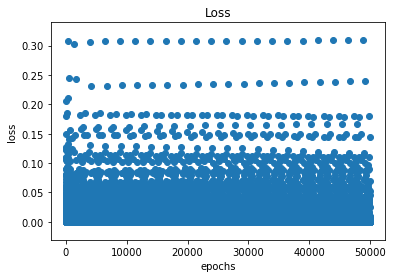

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

#### Denormalize

In [26]:
Price = pd.DataFrame(xTest)
Price.head(10)

,0,1,2,3
0,0.015546,-0.337564,0.009105,-0.095114
1,-0.099627,-0.495842,-0.373134,0.010468
2,-0.112732,-0.550224,-0.485077,-0.033356
3,-0.120137,-0.545090,-0.533612,-0.081529
4,-0.075559,-0.429199,-0.272494,-0.050412
5,-0.077291,-0.362297,-0.344597,-0.049347
6,-0.053380,-0.391495,-0.196150,-0.046806
7,-0.109182,-0.422983,-0.304980,0.060565
8,-0.118009,-0.237661,-0.370276,-0.001171
9,-0.051010,-0.350859,-0.317171,-0.024236


In [27]:
test_pred_list[:] = [(x*price_changeRange)+price_changeMean for x in test_pred_list]
xTest[:] = [(x*price_changeRange)+price_changeMean for x in xTest]
yTest[:] = [(y*price_changeRange)+price_changeMean for y in yTest]

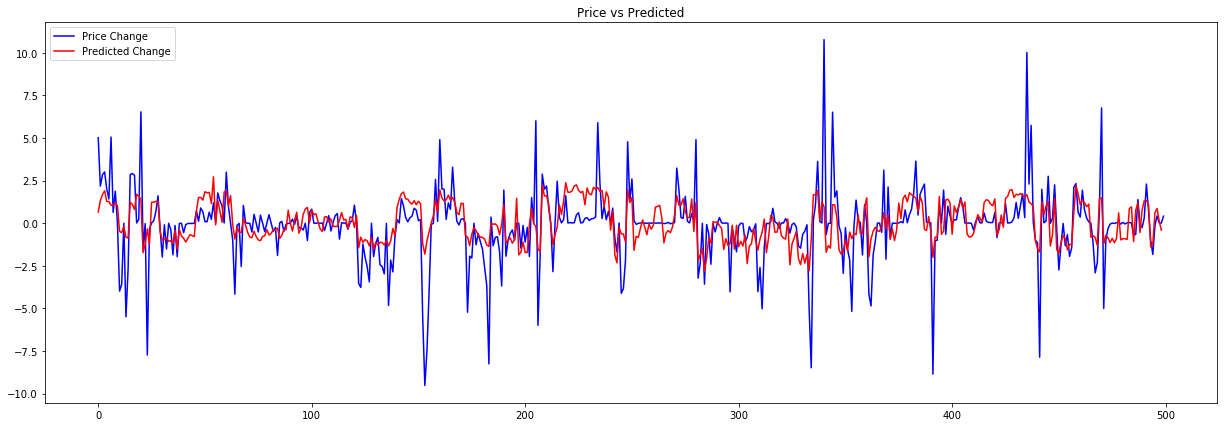

In [28]:
from scipy.ndimage.interpolation import shift
predicted=shift(test_pred_list, -5, cval=0)
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price Change',color='blue')
#plt.plot(xTest[:,0],label='Baseline')
plt.plot(test_pred_list,label='Predicted Change',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

In [29]:
len(test_pred_list)

499

In [30]:
pd.DataFrame(test_pred_list, columns=['Prediction']).tail()

,Prediction
494,-1.240077
495,0.621806
496,0.855040
497,0.107542
498,-0.412907


In [31]:
predict= pd.DataFrame(test_pred_list, columns=['Prediction'])
Target = pd.DataFrame(yTest, columns=['Target'])
Price = pd.DataFrame(xTest[:,0], columns=['Price'])
realVSpredict = predict.join(Target)
realVSpredict = realVSpredict.join(Price)
with pd.option_context('display.max_rows', None, 'display.max_columns', 4):
    print(realVSpredict)

     Prediction        Target     Price
0      0.652045  5.010000e+00  0.310667
1      1.317934  2.170000e+00 -2.379782
2      1.667631  2.840000e+00 -2.685900
3      1.899359  3.000000e+00 -2.858901
4      1.269428  2.000000e+00 -1.817550
5      1.265155  1.420000e+00 -1.858005
6      1.049237  5.050000e+00 -1.299449
7      1.065608  6.300000e-01 -2.602977
8      1.192022  1.870000e+00 -2.809185
9      1.014957  3.000000e-02 -1.244079
10    -0.486438 -3.990000e+00  0.420749
11    -0.562623 -3.590000e+00  0.832251
12    -0.196144 -1.000000e-02  0.042077
13    -0.831144 -5.500000e+00  1.418918
14    -0.870451 -2.690000e+00  0.742589
15     1.221860  2.850000e+00 -1.415931
16     1.097576  2.910000e+00 -1.243842
17     0.798382  2.800000e+00 -0.577233
18     1.693832  1.000000e-02 -3.474559
19     1.576249  2.100000e-01 -2.464940
20     1.393750  6.530000e+00 -1.535658
21    -1.736871 -1.490000e+00  3.582503
22    -1.244893 -3.000000e-02  3.025232
23    -0.340405 -7.740000e+00  0.991859


In [32]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(realVSpredict['Prediction'],realVSpredict['Target'])
print("r-squared:", r_value**2)

r-squared: 0.321556676681


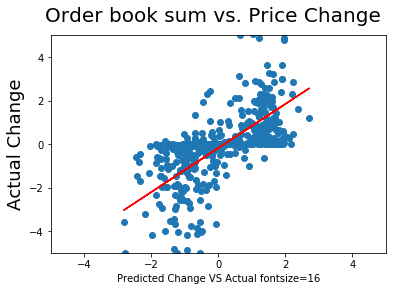

In [33]:

plt.scatter (realVSpredict['Prediction'],realVSpredict['Target'])
plt.suptitle('Order book sum vs. Price Change', fontsize=20)
plt.plot(realVSpredict['Prediction'], intercept + slope*(realVSpredict['Prediction']), 'r', label='fitted line')
plt.ylabel('Actual Change', fontsize=18)
plt.ylim( (-5, 5) )
plt.xlim(-5, 5)
plt.xlabel('Predicted Change VS Actual fontsize=16')
plt.show()

In [34]:
Price = pd.DataFrame(xTest[:,0])
Price.head(10)

,0
0,0.310667
1,-2.379782
2,-2.685900
3,-2.858901
4,-1.817550
5,-1.858005
6,-1.299449
7,-2.602977
8,-2.809185
9,-1.244079


In [35]:
tdt[-3:]

,order_date_time,id
2497,2017-10-04 14:53:17,145770.5
2498,2017-10-04 14:53:19,145778.0
2499,2017-10-04 14:53:24,145792.5


In [36]:
length=len(Price.index)


In [37]:

#pd.to_datetime(tdt,format='%Y%m%d %H:%M:%S.%f')

In [38]:
ds=dataset[-length:]
#backtrader_data= tdt[-length:]
Open=ds['TradePrice']
High= ds['TradePrice']
Low= ds['TradePrice']
Close= ds['TradePrice']
#Rnn10= ds.join(Price)

backtrader_data = pd.concat([tdt[-length:],Open, High, Low, Close], axis=1)
#date_time=pd.to_datetime(backtrader_data.trades_date_time, format="%Y%m%d %H:%M:%S.%f").to_frame()
#backtrader_data = backtrader_data.drop(backtrader_data.index[range(0,5)])
backtrader_data.head(20)


KeyError: 'TradePrice'

In [ ]:
backtrader_data = backtrader_data.reset_index(drop=True)
backtrader_data.join(predict)

In [ ]:
backtrader_data=pd.to_datetime(backtrader_data['order_date_time']).to_frame()
backtrader_data.set_index('order_date_time')
#backtrader_data=backtrader_data.drop_duplicates(['trades_date_time'])
backtrader_data = backtrader_data.resample('s').mean()

In [ ]:
backtrader_data.to_csv('BTCUSD_RNN10.csv',index=False)

In [ ]:
backtrader_data.index